In [32]:
import pandas as pd
from sqlalchemy import create_engine
import nltk
from nltk.tokenize import RegexpTokenizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer 
import string
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, auc
from sklearn.metrics import roc_curve, make_scorer, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from matplotlib.legend_handler import HandlerLine2D 
import scipy
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from vecstack import stacking
from sklearn.model_selection import GridSearchCV

In [33]:
stopwords = set(['ourselves', 'between', 'but', 'again','there', 'about', 'once', \
                 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an',\
                 'be', 'some', 'for', 'do', 'its', 'such', 'into', 'of', 'most', 
                 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from',\
                 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your',\
                 'through', 'don', 'nor', 'me', 'were', 'more',\
                 'this', 'down', 'should', 'our', 'their', 'while', 'above', \
                 'both', 'up', 'to', 'ours', 'had', 'all', 'no', 'when'\
                 , 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', \
                 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', \
                 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', \
                 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those'\
                 , 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against',\
                 'a', 'by', 'doing', 'it', 'how','b','the', 'you', 'further', 'href', \
                 'was', 'here', 'than','you'])

In [34]:
d = pd.read_csv("sample_data.csv")

In [35]:
scorer={'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score),
        'precision': make_scorer(precision_score, pos_label=1, average='binary'),
        'recall': make_scorer(recall_score), 
        'mean_squared_error': make_scorer(mean_squared_error)}

In [36]:
X_train, X_test, y_train, y_test= train_test_split(d.loc[:, 'text_info'],\
                                                       d.loc[:, 'bechdal_int'], test_size = 0.2)
v2 = TfidfVectorizer(analyzer='word',use_idf=True, ngram_range=(2,2), \
                         token_pattern= r'\w{1,}', stop_words=stopwords, sublinear_tf=True)
train_X = v2.fit_transform(X_train)
test_X = v2.transform(X_test)

In [37]:
#Random Forest

In [38]:
parameters = {'n_estimators' : [10, 20, 50]}
rf_clf = RandomForestClassifier(max_depth=4,
                               random_state=0)
rf_gs_clf = GridSearchCV(rf_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
rf_gs_clf.fit(train_X, y_train)
rf_gs_y_pred = rf_gs_clf.predict(test_X)
rf_grid_search_results = rf_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [39]:
rf_grid_search_results_with_scorer = rf_gs_clf.cv_results_

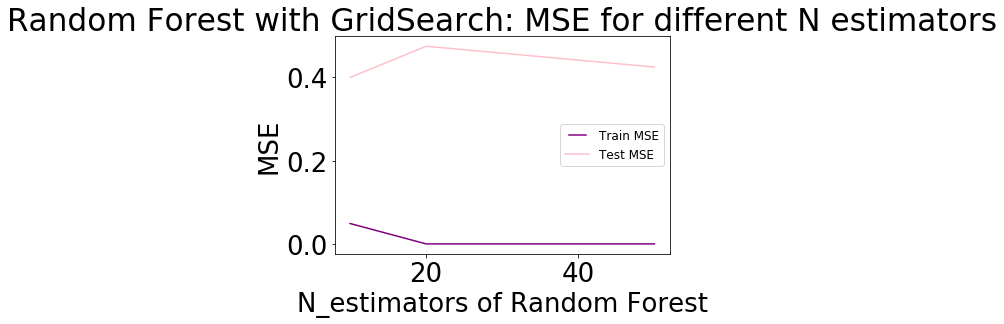

In [40]:
rf_gs_test = [x for x in rf_grid_search_results_with_scorer['mean_test_mean_squared_error']]
rf_gs_tr = [x for x in rf_grid_search_results_with_scorer['mean_train_mean_squared_error']]
line1, = plt.plot(rf_grid_search_results_with_scorer['param_n_estimators'].data, rf_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(rf_grid_search_results_with_scorer['param_n_estimators'].data, rf_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('N_estimators of Random Forest')
plt.title("Random Forest with GridSearch: MSE for different N estimators")
plt.show()

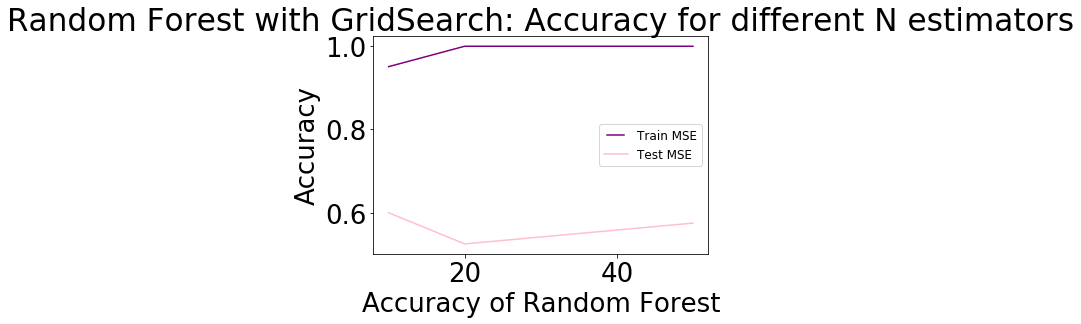

In [41]:
rf_gs_test_acc = [x for x in rf_grid_search_results_with_scorer['mean_test_accuracy']]
rf_gs_tr_acc = [x for x in rf_grid_search_results_with_scorer['mean_train_accuracy']]
line1, = plt.plot(rf_grid_search_results_with_scorer['param_n_estimators'].data, rf_gs_tr_acc, 'purple', label="Train MSE")
line2, = plt.plot(rf_grid_search_results_with_scorer['param_n_estimators'].data, rf_gs_test_acc, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuracy')
plt.xlabel('Accuracy of Random Forest')
plt.title("Random Forest with GridSearch: Accuracy for different N estimators")
plt.show()

#D Tree Depth 2 was best

In [42]:
parameters = {'max_depth' : range(2,7)}
dt_clf = tree.DecisionTreeClassifier()
dt_gs_clf = GridSearchCV(dt_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
dt_gs_clf.fit(train_X, y_train)
dt_gs_y_pred = dt_gs_clf.predict(test_X)
dt_grid_search_results = dt_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [43]:
dt_grid_search_results_with_scorer = dt_gs_clf.cv_results_

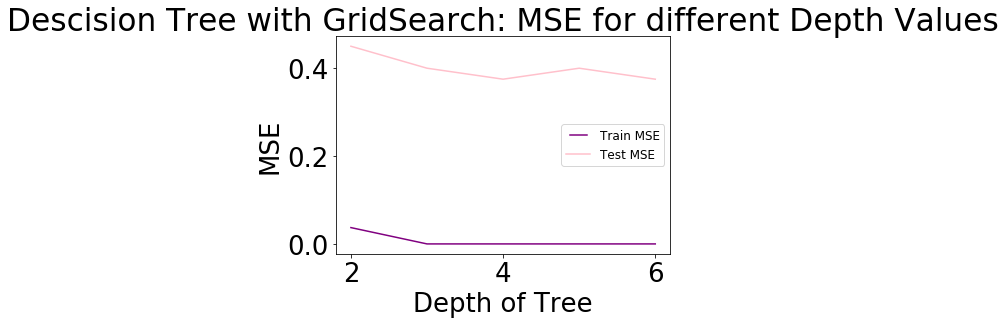

In [44]:
dt_gs_test = [x for x in dt_grid_search_results_with_scorer['mean_test_mean_squared_error']]
dt_gs_tr = [x for x in dt_grid_search_results_with_scorer['mean_train_mean_squared_error']]
line1, = plt.plot(dt_grid_search_results_with_scorer['param_max_depth'].data, dt_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(dt_grid_search_results_with_scorer['param_max_depth'].data, dt_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('Depth of Tree')
plt.title("Descision Tree with GridSearch: MSE for different Depth Values")
plt.show()

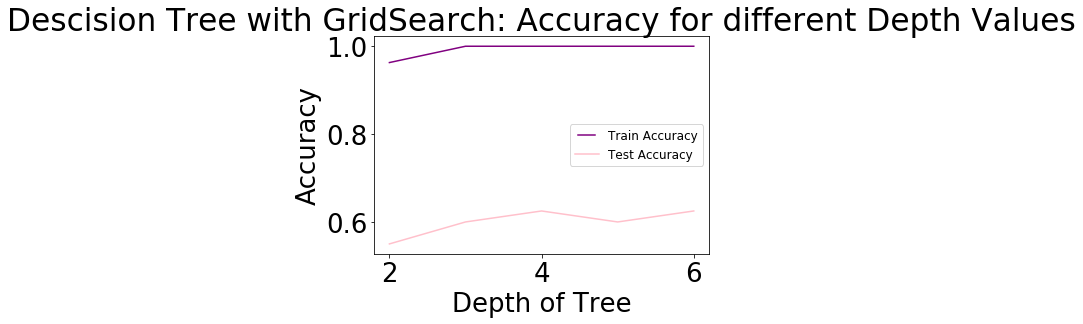

In [45]:
dt_gs_test_acc = [x for x in dt_grid_search_results_with_scorer['mean_test_accuracy']]
dt_gs_tr_acc = [x for x in dt_grid_search_results_with_scorer['mean_train_accuracy']]
line1, = plt.plot(dt_grid_search_results_with_scorer['param_max_depth'].data, dt_gs_tr_acc, 'purple', label="Train Accuracy")
line2, = plt.plot(dt_grid_search_results_with_scorer['param_max_depth'].data, dt_gs_test_acc, 'pink', label="Test Accuracy")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuracy')
plt.xlabel('Depth of Tree')
plt.title("Descision Tree with GridSearch: Accuracy for different Depth Values")
plt.show()

dt_gs_test = [x for x in grid_search_results_with_scorer['mean_test_mean_squared_error']]
dt_gs_tr = [x for x in grid_search_results_with_scorer['mean_train_mean_squared_error']]
line1, = plt.plot(grid_search_results_with_scorer['param_max_depth'].data, dt_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(grid_search_results_with_scorer['param_max_depth'].data, dt_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('Depth of Tree')
plt.title("Descision Tree with GridSearch: MSE for different Depth Values")
plt.show()

In [46]:
from sklearn.linear_model import LogisticRegression
parameters = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
lr_clf =  LogisticRegression()
lr_gs_clf = GridSearchCV(lr_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
lr_gs_clf.fit(train_X, y_train)
lr_gs_y_pred = lr_gs_clf.predict(test_X)
lr_grid_search_results = lr_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in 

In [47]:
lr_grid_search_results_with_scorer = lr_gs_clf.cv_results_

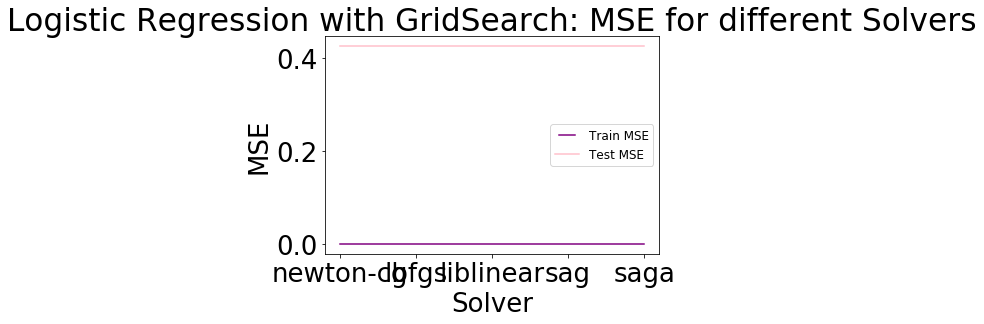

In [48]:
lr_gs_test = [x for x in lr_grid_search_results_with_scorer['mean_test_mean_squared_error']]
lr_gs_tr = [x for x in lr_grid_search_results_with_scorer['mean_train_mean_squared_error']]
line1, = plt.plot(lr_grid_search_results_with_scorer['param_solver'].data, lr_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(lr_grid_search_results_with_scorer['param_solver'].data, lr_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('Solver')
plt.title("Logistic Regression with GridSearch: MSE for different Solvers")
plt.show()

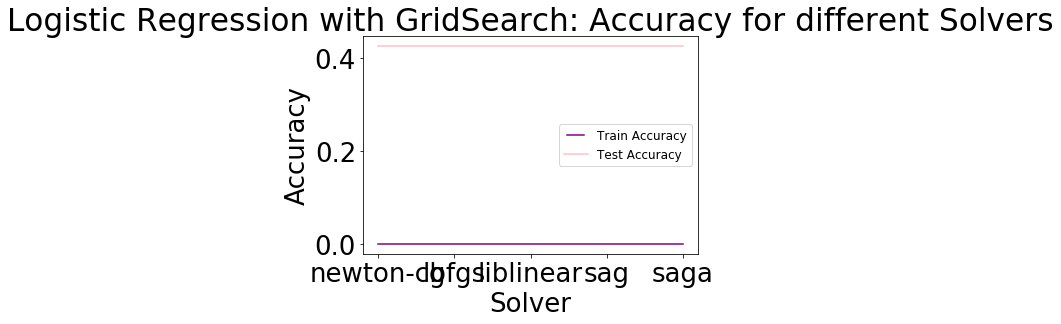

In [49]:
lr_gs_test_acc = [x for x in lr_grid_search_results_with_scorer['mean_test_accuracy']]
lr_gs_tr_acc = [x for x in lr_grid_search_results_with_scorer['mean_train_accuracy']]
line1, = plt.plot(lr_grid_search_results_with_scorer['param_solver'].data, lr_gs_tr, 'purple', label="Train Accuracy")
line2, = plt.plot(lr_grid_search_results_with_scorer['param_solver'].data, lr_gs_test, 'pink', label="Test Accuracy")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuracy')
plt.xlabel('Solver')
plt.title("Logistic Regression with GridSearch: Accuracy for different Solvers")
plt.show()

# Naive Bayes

In [50]:
parameters = {'alpha' : [0.001,0.1,.4,.5]}
nb_clf =  MultinomialNB()
nb_gs_clf = GridSearchCV(nb_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
nb_gs_clf.fit(train_X, y_train)
nb_gs_y_pred = nb_gs_clf.predict(test_X)
nb_grid_search_results = nb_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F

In [51]:
nb_grid_search_results_with_scorer = nb_gs_clf.cv_results_

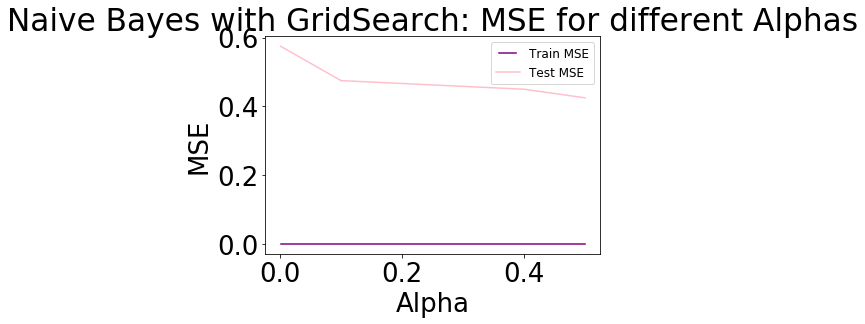

In [52]:
nb_gs_test = [x for x in nb_grid_search_results_with_scorer['mean_test_mean_squared_error']]
nb_gs_tr = [x for x in nb_grid_search_results_with_scorer['mean_train_mean_squared_error']]
line1, = plt.plot(nb_grid_search_results_with_scorer['param_alpha'].data, nb_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(nb_grid_search_results_with_scorer['param_alpha'].data, nb_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('Alpha')
plt.title("Naive Bayes with GridSearch: MSE for different Alphas")
plt.show()

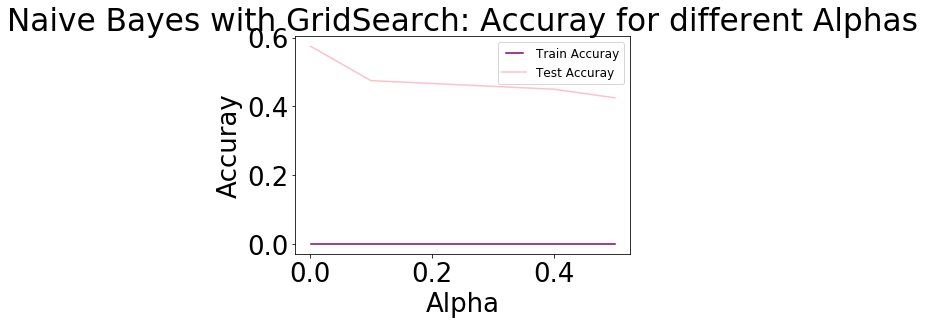

In [53]:
nb_gs_test_acc = [x for x in nb_grid_search_results_with_scorer['mean_test_accuracy']]
nb_gs_tr_acc = [x for x in nb_grid_search_results_with_scorer['mean_train_accuracy']]
line1, = plt.plot(nb_grid_search_results_with_scorer['param_alpha'].data, nb_gs_tr, 'purple', label="Train Accuray")
line2, = plt.plot(nb_grid_search_results_with_scorer['param_alpha'].data, nb_gs_test, 'pink', label="Test Accuray")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuray')
plt.xlabel('Alpha')
plt.title("Naive Bayes with GridSearch: Accuray for different Alphas")
plt.show()

# Ada boost 

In [54]:
ad_dt_clf = tree.DecisionTreeClassifier(max_depth=2)
parameters = { 'n_estimators': [10,30,50,70]}
ab_clf =  AdaBoostClassifier(ad_dt_clf)
ab_gs_clf = GridSearchCV(ab_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
ab_gs_clf.fit(train_X, y_train)
ab_gs_y_pred = ab_gs_clf.predict(test_X)
ab_grid_search_results = ab_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [55]:
ab_grid_search_results_with_scorer = ab_gs_clf.cv_results_

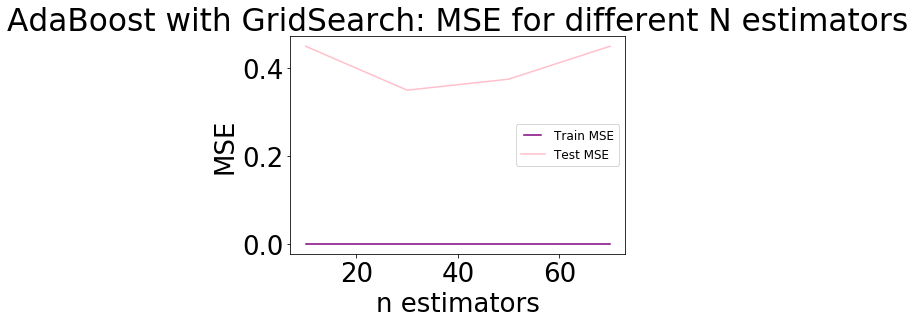

In [56]:
ab_gs_test = [x for x in ab_grid_search_results_with_scorer['mean_test_mean_squared_error']]
ab_gs_tr = [x for x in ab_grid_search_results_with_scorer['mean_train_mean_squared_error']]
ab_gs_lab = ab_grid_search_results_with_scorer['param_n_estimators'].data
line1, = plt.plot(ab_gs_lab , ab_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(ab_gs_lab, ab_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('n estimators')
plt.title("AdaBoost with GridSearch: MSE for different N estimators")
plt.show()

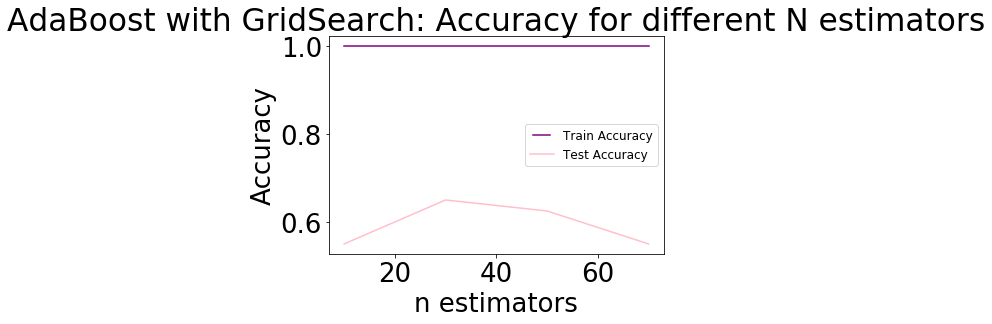

In [57]:
ab_gs_test_acc = [x for x in ab_grid_search_results_with_scorer['mean_test_accuracy']]
ab_gs_tr_acc = [x for x in ab_grid_search_results_with_scorer['mean_train_accuracy']]
ab_gs_lab = ab_grid_search_results_with_scorer['param_n_estimators'].data
line1, = plt.plot(ab_gs_lab , ab_gs_tr_acc, 'purple', label="Train Accuracy")
line2, = plt.plot(ab_gs_lab, ab_gs_test_acc, 'pink', label="Test Accuracy")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuracy')
plt.xlabel('n estimators')
plt.title("AdaBoost with GridSearch: Accuracy for different N estimators")
plt.show()

# Gradient Boosting

In [63]:
parameters = { 'n_estimators': [1, 5, 10,30,50,70,100]}
gb_clf =  GradientBoostingClassifier()
gb_gs_clf = GridSearchCV(gb_clf, parameters, cv=5,\
                      return_train_score=True, \
                      scoring=scorer,refit='mean_squared_error' )
gb_gs_clf.fit(train_X, y_train)
gb_gs_y_pred = gb_gs_clf.predict(test_X)
gb_grid_search_results = gb_gs_clf.cv_results_.keys()

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [64]:
gb_grid_search_results_with_scorer = gb_gs_clf.cv_results_

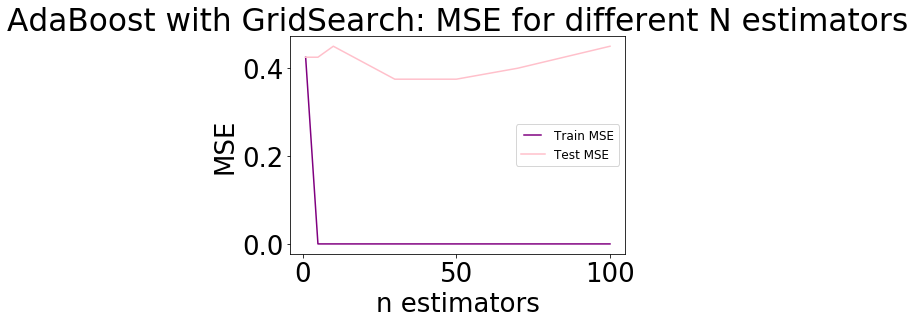

In [65]:
gb_gs_test = [x for x in gb_grid_search_results_with_scorer['mean_test_mean_squared_error']]
gb_gs_tr = [x for x in gb_grid_search_results_with_scorer['mean_train_mean_squared_error']]
gb_gs_lab = gb_grid_search_results_with_scorer['param_n_estimators'].data
line1, = plt.plot(gb_gs_lab , gb_gs_tr, 'purple', label="Train MSE")
line2, = plt.plot(gb_gs_lab, gb_gs_test, 'pink', label="Test MSE")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('MSE')
plt.xlabel('n estimators')
plt.title("AdaBoost with GridSearch: MSE for different N estimators")
plt.show()

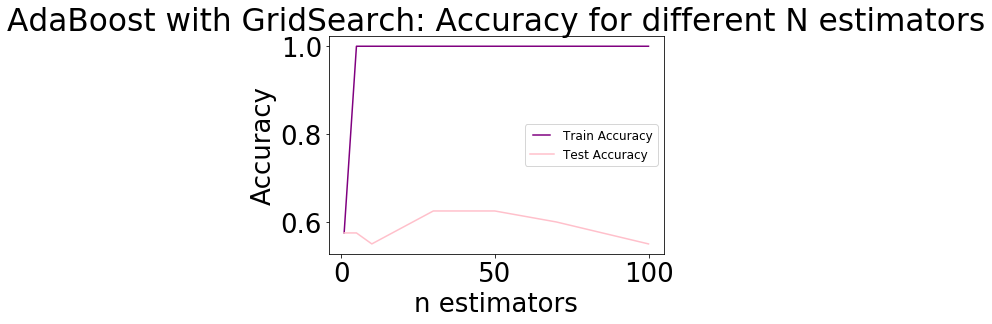

In [66]:
gb_gs_test_acc = [x for x in gb_grid_search_results_with_scorer['mean_test_accuracy']]
gb_gs_tr_acc = [x for x in gb_grid_search_results_with_scorer['mean_train_accuracy']]
gb_gs_lab = gb_grid_search_results_with_scorer['param_n_estimators'].data
line1, = plt.plot(gb_gs_lab , gb_gs_tr_acc, 'purple', label="Train Accuracy")
line2, = plt.plot(gb_gs_lab, gb_gs_test_acc, 'pink', label="Test Accuracy")
plt.rcParams.update({'font.size': 12})
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.rcParams.update({'font.size': 26})
plt.ylabel('Accuracy')
plt.xlabel('n estimators')
plt.title("AdaBoost with GridSearch: Accuracy for different N estimators")
plt.show()

# Stacks

In [85]:
dTree = tree.DecisionTreeClassifier(max_depth = 4)
nb = MultinomialNB(alpha =0.1)
rf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators = 50)
ab = AdaBoostClassifier(dTree, n_estimators =50)
lr = LogisticRegression(solver = 'lbfgs')


models = [dTree,nb,rf,ab,lr]

In [86]:
r1_train, r1_test = stacking(models,train_X, y_train, test_X, regression=False, \
                           mode='oof_pred_bag', save_dir=None, metric=accuracy_score, \
                           n_folds=5, stratified=True,shuffle=True,verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.55555556]
    fold  2:  [0.50000000]
    fold  3:  [0.71428571]
    fold  4:  [1.00000000]
    ----
    MEAN:     [0.68730159] + [0.17399606]
    FULL:     [0.67500000]

model  1:     [MultinomialNB]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.37500000]
    fold  3:  [0.28571429]
    fold  4:  [0.42857143]
    ----
    MEAN:     [0.44007937] + [0.10475289]
    FULL:     [0.45000000]

model  2:     [RandomForestClassifier]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.55555556]
    fold  2:  [0.50000000]
    fo

In [87]:
r1_train, r1_test = stacking(top_3_models,train_X, y_train, test_X, regression=False, \
                           mode='oof_pred_bag', save_dir=None, metric=accuracy_score, \
                           n_folds=5, stratified=True,shuffle=True,verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  1:     [LogisticRegression]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  2:     [AdaBoostClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.55555556]
    fold  2:  [0.50000000]
    fold  3:  [0.00000000]
    fold  4:  [0.71428571]
    ----
    MEAN:     [0.48730159] + [0.25533363]
    FULL:     [0.50000000]



In [88]:
model1 = AdaBoostClassifier(dTree, n_estimators = 50)
    
model1 = model1.fit(r1_train, y_train)
y_pred1 = model1.predict(r1_test)
accuracy_score(y_test, y_pred1)

0.2727272727272727

In [89]:
top_3_models  = [rf,lr,ab] # best performing combination

In [90]:
r2_train, r2_test = stacking(top_3_models,train_X, y_train, test_X, regression=False, \
                           mode='oof_pred_bag', save_dir=None, metric=accuracy_score, \
                           n_folds=5, stratified=True,shuffle=True,verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  1:     [LogisticRegression]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  2:     [AdaBoostClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.66666667]
    fold  2:  [0.50000000]
    fold  3:  [0.00000000]
    fold  4:  [1.00000000]
    ----
    MEAN:     [0.56666667] + [0.32659863]
    FULL:     [0.57500000]



In [91]:
model2 = AdaBoostClassifier(dTree, n_estimators = 50)
    
model2 = model2.fit(r2_train, y_train)
y_pred2 = model2.predict(r2_test)
accuracy_score(y_test, y_pred2)

0.5454545454545454

In [92]:
r_models  = [rf,nb,ab]

In [93]:
r3_train, r3_test = stacking(r_models,train_X, y_train, test_X, regression=False, \
                           mode='oof_pred_bag', save_dir=None, metric=accuracy_score, \
                           n_folds=5, stratified=True,shuffle=True,verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.62500000]
    fold  3:  [0.57142857]
    fold  4:  [0.57142857]
    ----
    MEAN:     [0.57579365] + [0.02560677]
    FULL:     [0.57500000]

model  1:     [MultinomialNB]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.37500000]
    fold  3:  [0.28571429]
    fold  4:  [0.42857143]
    ----
    MEAN:     [0.44007937] + [0.10475289]
    FULL:     [0.45000000]

model  2:     [AdaBoostClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.55555556]
    fold  2:  [0.50000000]
    fold  3:  [0.00000000]
    fold  4:  [1.00000000]
    ----
    MEAN:     [0.54444444] + [0.32279642]
    FULL:     [0.55000000]



In [94]:
model3 = AdaBoostClassifier(dTree, n_estimators = 50)
    
model3 = model3.fit(r3_train, y_train)
y_pred3 = model3.predict(r3_test)
accuracy_score(y_test, y_pred3)

0.45454545454545453

In [95]:
two_models  = [dTree,nb]

In [96]:
train2, test2 = stacking(two_models,train_X, y_train, test_X, regression=False, \
                           mode='oof_pred_bag', save_dir=None, metric=accuracy_score, \
                           n_folds=5, stratified=True,shuffle=True,verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.66666667]
    fold  1:  [0.66666667]
    fold  2:  [0.50000000]
    fold  3:  [0.00000000]
    fold  4:  [0.71428571]
    ----
    MEAN:     [0.50952381] + [0.26496053]
    FULL:     [0.52500000]

model  1:     [MultinomialNB]
    fold  0:  [0.55555556]
    fold  1:  [0.55555556]
    fold  2:  [0.37500000]
    fold  3:  [0.28571429]
    fold  4:  [0.42857143]
    ----
    MEAN:     [0.44007937] + [0.10475289]
    FULL:     [0.45000000]



In [97]:
simp_model = dTree
    
simp_model = simp_model.fit(train2, y_train)
y_pred_simp2 = simp_model.predict(test2)
accuracy_score(y_test, y_pred_simp2)

0.2727272727272727